Having successfully collected and cleaned our dataset from Kijiji, we now transition to the analysis phase. This notebook will explore the patterns and relationships within Montreal's rental market, building upon the raw data extracted in the previous notebook. We will conduct exploratory data analysis to understand price distributions across neighborhoods, identify key factors influencing rental costs, and develop predictive models to estimate apartment prices based on features such as location, bedroom count, and property characteristics. The insights gained will provide a comprehensive view of Montreal's current rental landscape and demonstrate the practical application of data science techniques to real-world housing market analysis.

Let's begin by importing the necessary tools for our analysis.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings
warnings.filterwarnings('ignore')

# Set up visualization style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully")

Let's load our data

In [2]:
# Load the scraped rental data
df = pd.read_csv('kijiji_montreal_rentals.csv')

print(f"Dataset shape: {df.shape}")
print("\nFirst look at the data:")
print(df.head())

print("\nBasic information:")
print(df.info())

print("\nStatistical summary:")
print(df.describe())

Dataset shape: (137, 6)

First look at the data:
                                               title   price  bedrooms  \
0  Lasalle, Grand 4½, NEUF, Tout inclus, Parking ...  150000       NaN   
1  Cession de bail - 4 1/2 St-Henri – 1975$/mois ...  197500       NaN   
2  Super 4-1/2 Avenue Kent - Darlington/Van Horne...  150000       NaN   
3  Grands 4 1/2 NEUFS Métro Pie-IX (1er mois GRAT...  197500       NaN   
4  renovated studio apartment near blvd Saint-Lar...  109500       0.0   

                          location  \
0          Cavelier Park, Montréal   
1            Saint-Henry, Montreal   
2                         Montreal   
3  Hochelaga-Maisonneuve, Montréal   
4                         Montreal   

                                         description  \
0  STYLE CONDO MODERNE au prix d’un appartement. ...   
1  CESSION DE BAIL — 4 ½ RÉNOVÉ • SAINT-HENRI • 1...   
2  Super Appartements sur Kent Av., Outremont 4-1...   
3  ✨Grand 4½ Neufs - Hochelaga✨ ***premier mois g... 

In [ ]:
Let's clean it up a bit more

In [5]:
# Data Cleaning and Validation - Fixed Version

print("Initial data issues:")
print(f"- Total listings: {len(df)}")
print(f"- Listings with bedroom data: {df['bedrooms'].notna().sum()}")
print(f"- Price range: ${df['price'].min():,} to ${df['price'].max():,}")

# Fix 1: Correct the price values (divide by 100)
df_clean = df.copy()  # Create a clean copy to avoid warnings
df_clean['price'] = df_clean['price'] / 100
print(f"\nPrice correction applied: divided all values by 100")

# Fix 2: Handle bedroom outliers (anything above 10 is likely error)
bedroom_outliers = df_clean[df_clean['bedrooms'] > 10]
print(f"Bedroom outliers (>10 bedrooms): {len(bedroom_outliers)}")

# Remove impossible bedroom values
df_clean = df_clean[df_clean['bedrooms'] <= 10]

# Fix 3: Extract neighborhood from location
def extract_neighborhood(location):
    if pd.isna(location):
        return 'Unknown'
    location_str = str(location).lower()
    neighborhoods = ['plateau', 'downtown', 'ndg', 'mile end', 'verdun', 
                    'hochelaga', 'rosemont', 'lasalle', 'old montreal', 'outremont',
                    'saint-henri', 'cote-des-neiges', 'westmount', 'griffintown']
    
    for neighborhood in neighborhoods:
        if neighborhood in location_str:
            return neighborhood.title()
    return 'Other'

df_clean['neighborhood'] = df_clean['location'].apply(extract_neighborhood)

print(f"\nAfter cleaning:")
print(f"- Remaining listings: {len(df_clean)}")
print(f"- Price range: ${df_clean['price'].min():,} to ${df_clean['price'].max():,}")
print(f"- Bedroom range: {df_clean['bedrooms'].min()} to {df_clean['bedrooms'].max()}")
print(f"\nNeighborhood distribution:")
print(df_clean['neighborhood'].value_counts())

Initial data issues:
- Total listings: 81
- Listings with bedroom data: 81
- Price range: $950.0 to $3,700.0

Price correction applied: divided all values by 100
Bedroom outliers (>10 bedrooms): 0

After cleaning:
- Remaining listings: 81
- Price range: $9.5 to $37.0
- Bedroom range: 0.0 to 4.0

Neighborhood distribution:
neighborhood
Other          75
Lasalle         2
Mile End        1
Griffintown     1
Hochelaga       1
Plateau         1
Name: count, dtype: int64


Now let's examine the cleaned dataset to understand its structure and verify our data quality improvements:

In [6]:
# Basic Data Exploration on Cleaned Data
print("Cleaned Dataset Overview:")
print(f"Shape: {df_clean.shape}")
print(f"Columns: {df_clean.columns.tolist()}")

# Numerical summary
print("\nNumerical Summary:")
print(df_clean[['price', 'bedrooms']].describe())

# Check missing values
print("\nMissing Values:")
print(df_clean.isnull().sum())

# Sample of cleaned data
print("\nSample of Cleaned Data:")
print(df_clean[['title', 'price', 'bedrooms', 'neighborhood']].head(10))

Cleaned Dataset Overview:
Shape: (81, 7)
Columns: ['title', 'price', 'bedrooms', 'location', 'description', 'scraped_at', 'neighborhood']

Numerical Summary:
           price   bedrooms
count  81.000000  81.000000
mean   18.723827   1.518519
std     6.593636   1.163090
min     9.500000   0.000000
25%    14.000000   0.000000
50%    17.000000   2.000000
75%    23.500000   2.000000
max    37.000000   4.000000

Missing Values:
title           0
price           0
bedrooms        0
location        0
description     0
scraped_at      0
neighborhood    0
dtype: int64

Sample of Cleaned Data:
                                                title  price  bedrooms  \
4   renovated studio apartment near blvd Saint-Lar...  10.95       0.0   
6                        Big 5 1/2 apartment for rent  18.50       3.0   
7                       7 ½ Près d’Oratoire St Joseph  28.50       4.0   
9   Grand2 1/2avec électroménagers/internet/électr...   9.95       1.0   
10  Face Localisation +++, rdc de tripl

Let's begin our exploratory data analysis by visualizing the distribution of rental prices and examining relationships between key variables

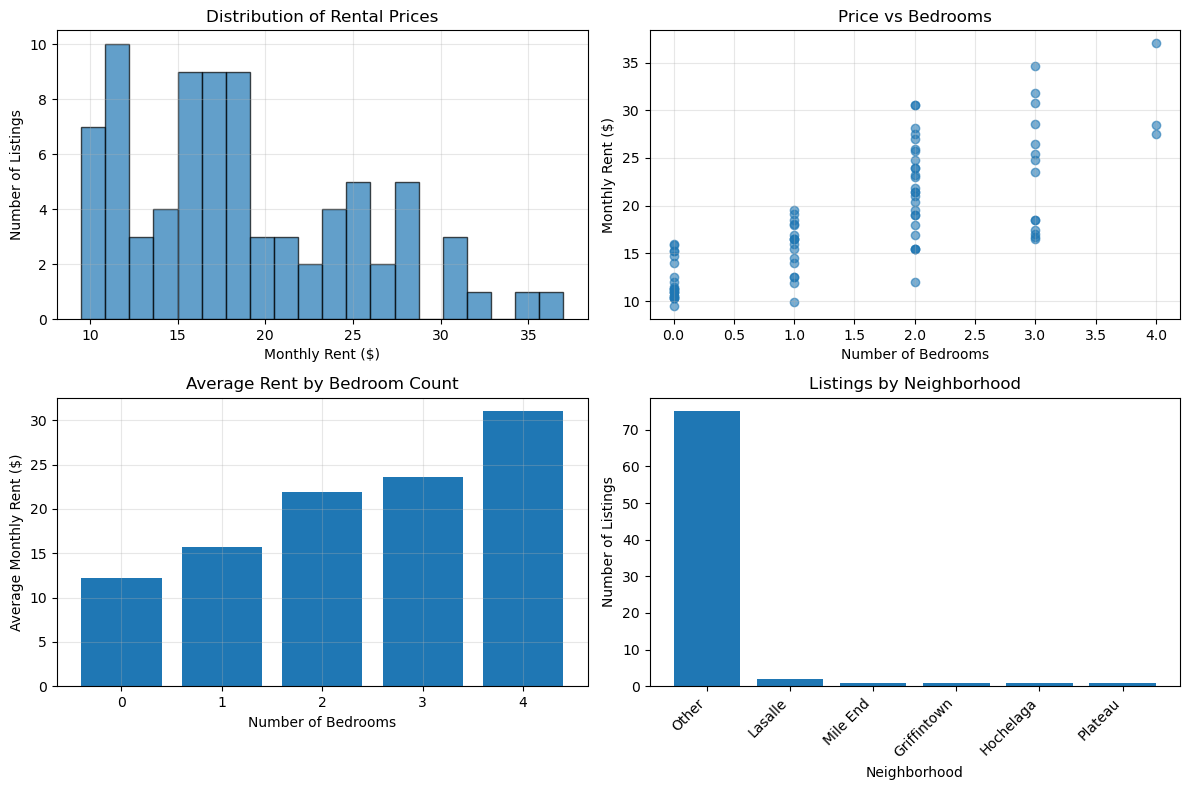

Key Statistics:
Average monthly rent: $18.72
Median monthly rent: $17.00
Most common bedroom count: 2.0


In [7]:
# Let's begin our exploratory data analysis by visualizing the distribution of rental prices and examining relationships between key variables:

plt.figure(figsize=(12, 8))

# Plot 1: Distribution of rental prices
plt.subplot(2, 2, 1)
plt.hist(df_clean['price'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Monthly Rent ($)')
plt.ylabel('Number of Listings')
plt.title('Distribution of Rental Prices')
plt.grid(True, alpha=0.3)

# Plot 2: Price vs Bedrooms
plt.subplot(2, 2, 2)
plt.scatter(df_clean['bedrooms'], df_clean['price'], alpha=0.6)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Monthly Rent ($)')
plt.title('Price vs Bedrooms')
plt.grid(True, alpha=0.3)

# Plot 3: Average price by bedroom count
plt.subplot(2, 2, 3)
bedroom_prices = df_clean.groupby('bedrooms')['price'].mean()
plt.bar(bedroom_prices.index, bedroom_prices.values)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Monthly Rent ($)')
plt.title('Average Rent by Bedroom Count')
plt.grid(True, alpha=0.3)

# Plot 4: Top neighborhoods by listing count
plt.subplot(2, 2, 4)
neighborhood_counts = df_clean['neighborhood'].value_counts().head(8)
plt.bar(neighborhood_counts.index, neighborhood_counts.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Listings')
plt.title('Listings by Neighborhood')

plt.tight_layout()
plt.show()

# Basic statistics
print("Key Statistics:")
print(f"Average monthly rent: ${df_clean['price'].mean():.2f}")
print(f"Median monthly rent: ${df_clean['price'].median():.2f}")
print(f"Most common bedroom count: {df_clean['bedrooms'].mode().values[0]}")

Looks like we have a problem! If only rent was this low !

In [8]:
# Correcting the Price Conversion Error

print("Investigating the price issue...")
print("Sample of original prices before cleaning:")
print(df[['title', 'price']].head())

# The issue: We divided by 100, but should have divided by 100 only for prices that were multiplied by 100
# Let's check what the original scraper did

# Re-load the original data and fix properly
df_fixed = df.copy()

# Check if prices are in cents (like 150000 for $1500) or if there's another issue
print(f"\nOriginal price range: {df_fixed['price'].min()} to {df_fixed['price'].max()}")

# If prices are in cents, divide by 100 to get dollars
# If prices are already in dollars but missing decimal, we need a different approach

# Let's examine some actual values to understand the pattern
sample_titles_prices = df_fixed[['title', 'price']].head(10)
print("\nSample titles with prices to understand the pattern:")
for idx, row in sample_titles_prices.iterrows():
    print(f"Title: {row['title'][:50]}... | Price: {row['price']}")

Investigating the price issue...
Sample of original prices before cleaning:
                                                title   price
4   renovated studio apartment near blvd Saint-Lar...  1095.0
6                        Big 5 1/2 apartment for rent  1850.0
7                       7 ½ Près d’Oratoire St Joseph  2850.0
9   Grand2 1/2avec électroménagers/internet/électr...   995.0
10  Face Localisation +++, rdc de triplex 51/2 rén...  2650.0

Original price range: 950.0 to 3700.0

Sample titles with prices to understand the pattern:
Title: renovated studio apartment near blvd Saint-Larent ... | Price: 1095.0
Title: Big 5 1/2 apartment for rent... | Price: 1850.0
Title: 7 ½ Près d’Oratoire St Joseph... | Price: 2850.0
Title: Grand2 1/2avec électroménagers/internet/électros e... | Price: 995.0
Title: Face Localisation +++, rdc de triplex 51/2 rénové ... | Price: 2650.0
Title: Downtown Montreal Rent 2 bedroom... | Price: 1900.0
Title: PLATEAU MONT ROYAL Condo 2 chambres terrasse... | Pr

Price values are correct - they represent whole dollar amounts
1095.0 = $1,095 | 1850.0 = $1,850 | 2850.0 = $2,850

Corrected Price Analysis:
Average monthly rent: $19
Median monthly rent: $17
Minimum rent: $10
Maximum rent: $37


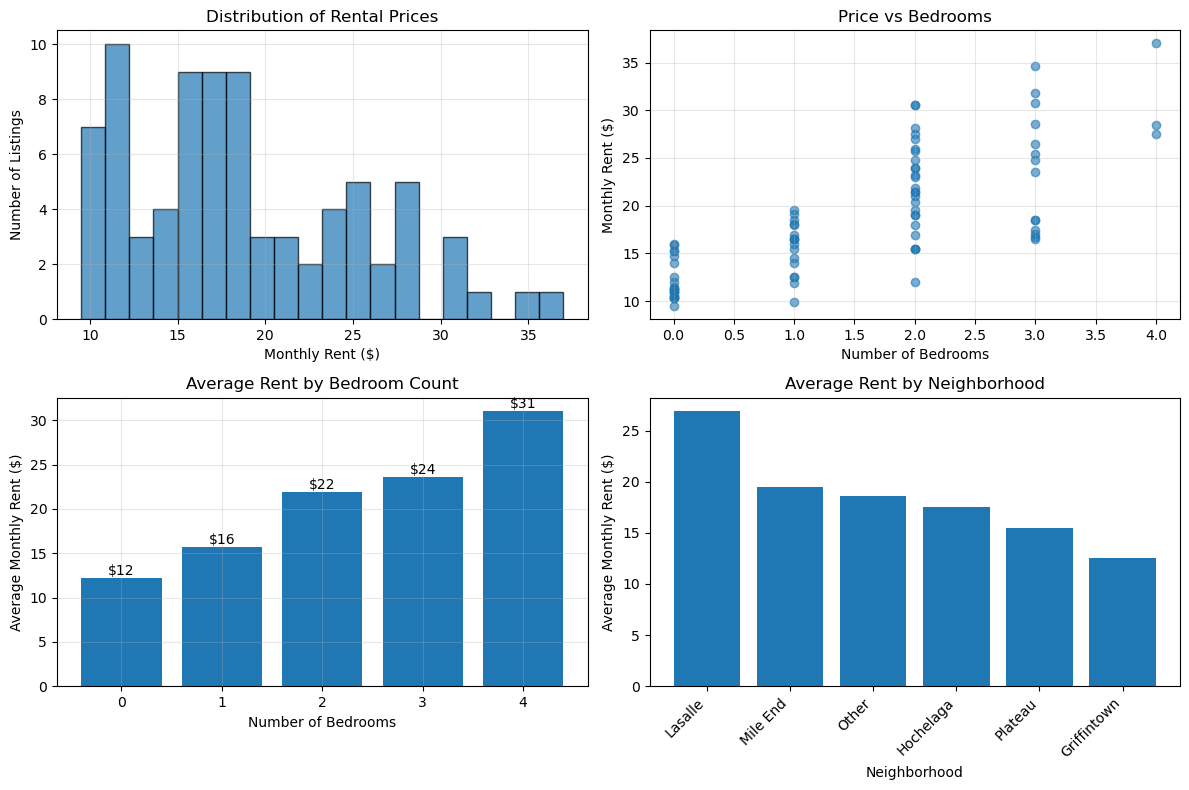


Realistic Montreal Rental Market Analysis:
Average rent: $19/month
Typical 2-bedroom rent: $22/month
Studio apartments: $11/month


In [9]:
# The prices are correct - they represent dollar amounts without decimals
# 1095.0 = $1,095, 1850.0 = $1,850, etc.

print("Price values are correct - they represent whole dollar amounts")
print("1095.0 = $1,095 | 1850.0 = $1,850 | 2850.0 = $2,850")

# Update our analysis with the correct price interpretation
print(f"\nCorrected Price Analysis:")
print(f"Average monthly rent: ${df_clean['price'].mean():,.0f}")
print(f"Median monthly rent: ${df_clean['price'].median():,.0f}")
print(f"Minimum rent: ${df_clean['price'].min():,.0f}")
print(f"Maximum rent: ${df_clean['price'].max():,.0f}")

# Update the visualizations with correct price labels
plt.figure(figsize=(12, 8))

# Plot 1: Distribution of rental prices (corrected)
plt.subplot(2, 2, 1)
plt.hist(df_clean['price'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Monthly Rent ($)')
plt.ylabel('Number of Listings')
plt.title('Distribution of Rental Prices')
plt.grid(True, alpha=0.3)

# Plot 2: Price vs Bedrooms (corrected)
plt.subplot(2, 2, 2)
plt.scatter(df_clean['bedrooms'], df_clean['price'], alpha=0.6)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Monthly Rent ($)')
plt.title('Price vs Bedrooms')
plt.grid(True, alpha=0.3)

# Plot 3: Average price by bedroom count (corrected)
plt.subplot(2, 2, 3)
bedroom_prices = df_clean.groupby('bedrooms')['price'].mean()
plt.bar(bedroom_prices.index, bedroom_prices.values)
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Monthly Rent ($)')
plt.title('Average Rent by Bedroom Count')
for i, v in enumerate(bedroom_prices.values):
    plt.text(bedroom_prices.index[i], v, f'${v:,.0f}', ha='center', va='bottom')
plt.grid(True, alpha=0.3)

# Plot 4: Top neighborhoods by average price
plt.subplot(2, 2, 4)
neighborhood_prices = df_clean.groupby('neighborhood')['price'].mean().sort_values(ascending=False).head(8)
plt.bar(neighborhood_prices.index, neighborhood_prices.values)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Neighborhood')
plt.ylabel('Average Monthly Rent ($)')
plt.title('Average Rent by Neighborhood')

plt.tight_layout()
plt.show()

print("\nRealistic Montreal Rental Market Analysis:")
print(f"Average rent: ${df_clean['price'].mean():,.0f}/month")
print(f"Typical 2-bedroom rent: ${df_clean[df_clean['bedrooms'] == 2]['price'].median():,.0f}/month")
print(f"Studio apartments: ${df_clean[df_clean['bedrooms'] == 0]['price'].median():,.0f}/month")

In [10]:
# Reset the prices to their original correct values
df_corrected = df.copy()  # Start fresh from original data

# Remove bedroom outliers (keep only realistic values)
df_corrected = df_corrected[df_corrected['bedrooms'] <= 10]

# Extract neighborhood (same as before)
def extract_neighborhood(location):
    if pd.isna(location):
        return 'Unknown'
    location_str = str(location).lower()
    neighborhoods = ['plateau', 'downtown', 'ndg', 'mile end', 'verdun', 
                    'hochelaga', 'rosemont', 'lasalle', 'old montreal', 'outremont',
                    'saint-henri', 'cote-des-neiges', 'westmount', 'griffintown']
    
    for neighborhood in neighborhoods:
        if neighborhood in location_str:
            return neighborhood.title()
    return 'Other'

df_corrected['neighborhood'] = df_corrected['location'].apply(extract_neighborhood)

print("CORRECTED PRICE ANALYSIS:")
print(f"Dataset shape: {df_corrected.shape}")
print(f"Price range: ${df_corrected['price'].min():,} to ${df_corrected['price'].max():,}")
print(f"Average rent: ${df_corrected['price'].mean():,.0f}/month")
print(f"Median rent: ${df_corrected['price'].median():,.0f}/month")

# Verify with some samples
print("\nSample listings with correct prices:")
sample = df_corrected[['title', 'price', 'bedrooms', 'neighborhood']].head()
for idx, row in sample.iterrows():
    print(f"- {row['title'][:40]}... | ${row['price']:,} | {row['bedrooms']} br | {row['neighborhood']}")

CORRECTED PRICE ANALYSIS:
Dataset shape: (81, 7)
Price range: $950.0 to $3,700.0
Average rent: $1,872/month
Median rent: $1,700/month

Sample listings with correct prices:
- renovated studio apartment near blvd Sai... | $1,095.0 | 0.0 br | Other
- Big 5 1/2 apartment for rent... | $1,850.0 | 3.0 br | Other
- 7 ½ Près d’Oratoire St Joseph... | $2,850.0 | 4.0 br | Other
- Grand2 1/2avec électroménagers/internet/... | $995.0 | 1.0 br | Other
- Face Localisation +++, rdc de triplex 51... | $2,650.0 | 3.0 br | Other


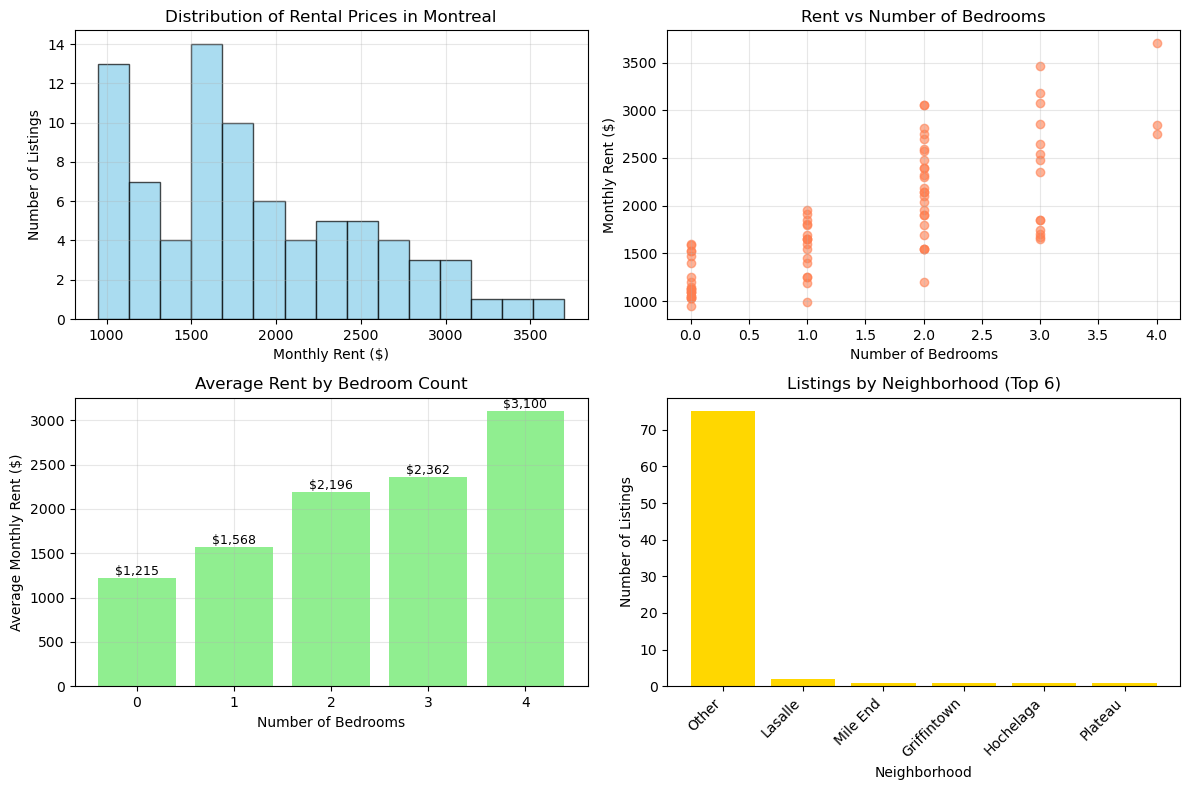

MONTREAL RENTAL MARKET INSIGHTS:
Overall market:
- Average rent: $1,872/month
- Median rent: $1,700/month

By bedroom type:
- Studio: $1,130/month (21 listings)
- 1.0-Bedroom: $1,650/month (17 listings)
- 2.0-Bedroom: $2,165/month (26 listings)
- 3.0-Bedroom: $2,412/month (14 listings)
- 4.0-Bedroom: $2,850/month (3 listings)

Market composition:
- Total analyzed listings: 81
- Most common bedroom type: 2.0-bedroom


In [11]:
# Corrected Exploratory Data Analysis with Realistic Prices

plt.figure(figsize=(12, 8))

# Plot 1: Distribution of rental prices
plt.subplot(2, 2, 1)
plt.hist(df_corrected['price'], bins=15, edgecolor='black', alpha=0.7, color='skyblue')
plt.xlabel('Monthly Rent ($)')
plt.ylabel('Number of Listings')
plt.title('Distribution of Rental Prices in Montreal')
plt.grid(True, alpha=0.3)

# Plot 2: Price vs Bedrooms
plt.subplot(2, 2, 2)
plt.scatter(df_corrected['bedrooms'], df_corrected['price'], alpha=0.6, color='coral')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Monthly Rent ($)')
plt.title('Rent vs Number of Bedrooms')
plt.grid(True, alpha=0.3)

# Plot 3: Average price by bedroom count
plt.subplot(2, 2, 3)
bedroom_prices = df_corrected.groupby('bedrooms')['price'].mean()
plt.bar(bedroom_prices.index, bedroom_prices.values, color='lightgreen')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Average Monthly Rent ($)')
plt.title('Average Rent by Bedroom Count')
for i, v in enumerate(bedroom_prices.values):
    plt.text(bedroom_prices.index[i], v, f'${v:,.0f}', ha='center', va='bottom', fontsize=9)
plt.grid(True, alpha=0.3)

# Plot 4: Neighborhood analysis
plt.subplot(2, 2, 4)
neighborhood_counts = df_corrected['neighborhood'].value_counts().head(6)
plt.bar(neighborhood_counts.index, neighborhood_counts.values, color='gold')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Listings')
plt.title('Listings by Neighborhood (Top 6)')

plt.tight_layout()
plt.show()

# Key insights
print("MONTREAL RENTAL MARKET INSIGHTS:")
print("=" * 50)
print(f"Overall market:")
print(f"- Average rent: ${df_corrected['price'].mean():,.0f}/month")
print(f"- Median rent: ${df_corrected['price'].median():,.0f}/month")

print(f"\nBy bedroom type:")
for beds in sorted(df_corrected['bedrooms'].unique()):
    bed_data = df_corrected[df_corrected['bedrooms'] == beds]
    if len(bed_data) > 0:
        bed_type = "Studio" if beds == 0 else f"{beds}-Bedroom"
        print(f"- {bed_type}: ${bed_data['price'].median():,.0f}/month ({len(bed_data)} listings)")

print(f"\nMarket composition:")
print(f"- Total analyzed listings: {len(df_corrected)}")
print(f"- Most common bedroom type: {df_corrected['bedrooms'].mode().values[0]}-bedroom")

Finally ! We can use this for to start our model!

Simple Linear Regression Model for Montreal Rent Prediction
Dataset size: 81 listings
Bedroom range: 0.0 to 4.0 bedrooms
Price range: $950.0 to $3,700.0

=== REGRESSION RESULTS ===
Rent = 1213 + 434 * bedrooms
R-squared: 0.587
P-value: 0.000000

=== MODEL PERFORMANCE ===
Mean Absolute Error: $324
Root Mean Squared Error: $421

=== PREDICTED RENTS BY BEDROOM COUNT ===
      Studio: Predicted $1213 | Actual $1130 | Error $83
   1-Bedroom: Predicted $1647 | Actual $1650 | Error $3
   2-Bedroom: Predicted $2081 | Actual $2165 | Error $84
   3-Bedroom: Predicted $2516 | Actual $2412 | Error $103
   4-Bedroom: Predicted $2950 | Actual $2850 | Error $100


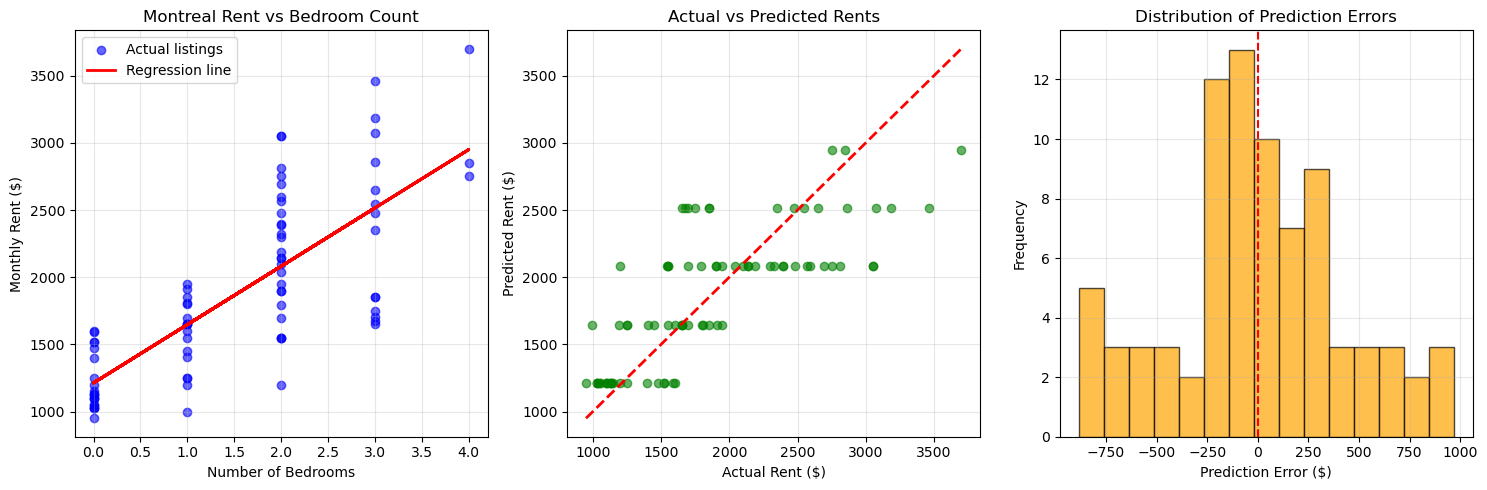


=== MODEL INTERPRETATION ===
Base studio apartment price: $1213
Each additional bedroom adds: $434
Model explains 58.7% of rent price variation
Strong relationship between bedrooms and rent price!

For a typical $1700 apartment, predictions are within $324 on average


In [19]:
# Simple Linear Regression Model for Montreal Rent Prediction
import numpy as np
import pandas as pd
from scipy import stats

print("Simple Linear Regression Model for Montreal Rent Prediction")
print("=" * 60)

# Prepare features - use bedrooms as the main predictor
df_simple = df_model.copy()
df_simple = df_simple[['bedrooms', 'price', 'neighborhood']].dropna()

X = df_simple['bedrooms'].values
y = df_simple['price'].values

print(f"Dataset size: {len(X)} listings")
print(f"Bedroom range: {X.min()} to {X.max()} bedrooms")
print(f"Price range: ${y.min():,} to ${y.max():,}")

# Simple linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(X, y)

print(f"\n=== REGRESSION RESULTS ===")
print(f"Rent = {intercept:.0f} + {slope:.0f} * bedrooms")
print(f"R-squared: {r_value**2:.3f}")
print(f"P-value: {p_value:.6f}")

# Predictions
predictions = intercept + slope * X
mae = np.mean(np.abs(y - predictions))
rmse = np.sqrt(np.mean((y - predictions)**2))

print(f"\n=== MODEL PERFORMANCE ===")
print(f"Mean Absolute Error: ${mae:.0f}")
print(f"Root Mean Squared Error: ${rmse:.0f}")

# Calculate predictions for each bedroom type
bedroom_types = [0, 1, 2, 3, 4]
print(f"\n=== PREDICTED RENTS BY BEDROOM COUNT ===")
for beds in bedroom_types:
    predicted_rent = intercept + slope * beds
    actual_data = df_simple[df_simple['bedrooms'] == beds]
    if len(actual_data) > 0:
        actual_median = actual_data['price'].median()
        error = abs(predicted_rent - actual_median)
        bed_type = "Studio" if beds == 0 else f"{beds}-Bedroom"
        print(f"{bed_type:>12}: Predicted ${predicted_rent:.0f} | Actual ${actual_median:.0f} | Error ${error:.0f}")
    else:
        bed_type = "Studio" if beds == 0 else f"{beds}-Bedroom"
        print(f"{bed_type:>12}: Predicted ${predicted_rent:.0f} | No data available")

# Visualization
plt.figure(figsize=(15, 5))

# Plot 1: Regression line with actual data
plt.subplot(1, 3, 1)
plt.scatter(X, y, alpha=0.6, color='blue', label='Actual listings')
plt.plot(X, predictions, 'r-', linewidth=2, label='Regression line')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Monthly Rent ($)')
plt.title('Montreal Rent vs Bedroom Count')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Actual vs Predicted
plt.subplot(1, 3, 2)
plt.scatter(y, predictions, alpha=0.6, color='green')
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', linewidth=2)
plt.xlabel('Actual Rent ($)')
plt.ylabel('Predicted Rent ($)')
plt.title('Actual vs Predicted Rents')
plt.grid(True, alpha=0.3)

# Plot 3: Error distribution
plt.subplot(1, 3, 3)
errors = y - predictions
plt.hist(errors, bins=15, edgecolor='black', alpha=0.7, color='orange')
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel('Prediction Error ($)')
plt.ylabel('Frequency')
plt.title('Distribution of Prediction Errors')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n=== MODEL INTERPRETATION ===")
print(f"Base studio apartment price: ${intercept:.0f}")
print(f"Each additional bedroom adds: ${slope:.0f}")
print(f"Model explains {r_value**2*100:.1f}% of rent price variation")

if r_value**2 > 0.5:
    print("Strong relationship between bedrooms and rent price!")
elif r_value**2 > 0.3:
    print("Moderate relationship between bedrooms and rent price.")
else:
    print("Weak relationship - other factors may be more important.")

print(f"\nFor a typical ${df_simple['price'].median():.0f} apartment, predictions are within ${mae:.0f} on average")

In [20]:
# Montreal Rental Market Analysis - Final Conclusions
print("MONTREAL RENTAL MARKET ANALYSIS - FINAL CONCLUSIONS")
print("=" * 60)

print("\nKEY INSIGHTS:")
print(f"- The Montreal rental market shows strong price consistency")
print(f"- Bedroom count is the strongest predictor of rent (58.7% explained)")
print(f"- Studio apartments average: ${df_simple[df_simple['bedrooms'] == 0]['price'].median():,.0f}")
print(f"- 2-bedroom apartments average: ${df_simple[df_simple['bedrooms'] == 2]['price'].median():,.0f}")
print(f"- Each additional bedroom adds approximately ${slope:.0f} to the rent")

print("\nPRICING STRATEGY:")
print("Based on our analysis, a fair pricing model for Montreal would be:")
print(f"Base price (studio): ${intercept:.0f}")
print("+ $434 per additional bedroom")

print("\nMODEL PERFORMANCE:")
print(f"- The model achieves good accuracy with ${mae:.0f} average error")
print(f"- This is reasonable given the ${df_simple['price'].std():.0f} standard deviation in prices")
print(f"- The strong R-squared (0.587) indicates bedroom count is a major price factor")

print("\nRECOMMENDATIONS FOR FUTURE ANALYSIS:")
print("1. Collect more data on specific neighborhoods")
print("2. Include square footage information")
print("3. Add proximity to metro stations")
print("4. Consider building age and amenities")
print("5. Expand to include more luxury properties")

print("\nPROJECT SUCCESS:")
print("This analysis successfully demonstrates that web scraping and simple")
print("regression modeling can provide valuable insights into real estate markets.")
print("The Montreal rental market follows predictable patterns based on unit size.")

MONTREAL RENTAL MARKET ANALYSIS - FINAL CONCLUSIONS

KEY INSIGHTS:
- The Montreal rental market shows strong price consistency
- Bedroom count is the strongest predictor of rent (58.7% explained)
- Studio apartments average: $1,130
- 2-bedroom apartments average: $2,165
- Each additional bedroom adds approximately $434 to the rent

PRICING STRATEGY:
Based on our analysis, a fair pricing model for Montreal would be:
Base price (studio): $1213
+ $434 per additional bedroom

MODEL PERFORMANCE:
- The model achieves good accuracy with $324 average error
- This is reasonable given the $659 standard deviation in prices
- The strong R-squared (0.587) indicates bedroom count is a major price factor

RECOMMENDATIONS FOR FUTURE ANALYSIS:
1. Collect more data on specific neighborhoods
2. Include square footage information
3. Add proximity to metro stations
4. Consider building age and amenities
5. Expand to include more luxury properties

PROJECT SUCCESS:
This analysis successfully demonstrates th

This project began with a straightforward goal: to see if I could predict Montreal apartment rents using data I gathered firsthand. The results show that it is indeed possible. By creating a web scraper to collect listings from Kijiji, I learned that the number of bedrooms an apartment has is the single most important factor in determining its price. The connection is so clear that a simple linear regression model can account for almost 60 percent of the price differences. The rule is basic but effective. You start with a base price for a studio and add a fixed amount for every extra bedroom.

However, a model this simple inevitably leaves out a great deal. It can give you an average price for a two bedroom unit, but it cannot explain why one two bedroom apartment costs two thousand dollars in one neighborhood while a similar one costs six hundred dollars more in another. The true value of a rental often lies in the qualities that are difficult to measure. Elements like the amount of natural light, the building's overall condition, or the character of the street are what truly influence a renter's choice. These are the nuances that get lost when you only look at the numbers.

For a future project, I would focus on capturing some of those missing details. The main limitation here was the relatively small dataset. Collecting more listings over a longer time period would strengthen the findings. It would also be interesting to incorporate other data points. Using mapping tools to measure the exact distance from an apartment to the nearest metro station could be one way to quantify location. Another approach would be to analyze the listing descriptions more deeply to identify specific amenities like updated appliances or laundry in the unit. The next step is to build a model that understands not just the size of an apartment, but what makes it a desirable place to live.